<a href="https://colab.research.google.com/github/MohebZandi/Comupter_Vision/blob/main/FMNIST_00.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Fashion MNIST


In [1]:
import numpy as np
import gzip
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Importing data 

### 1 - from Google Drive

### 2 - from torchvision

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
data_url_train = '/content/gdrive/MyDrive/FMNIST/train-images.gz'
data_url_labels = '/content/gdrive/MyDrive/FMNIST/train-labels.gz'

In [5]:
# importing data and labels

def training_images():
    with gzip.open(data_url_train, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of images
        image_count = int.from_bytes(f.read(4), 'big')
        # third 4 bytes is the row count
        row_count = int.from_bytes(f.read(4), 'big')
        # fourth 4 bytes is the column count
        column_count = int.from_bytes(f.read(4), 'big')
        # rest is the image pixel data, each pixel is stored as an unsigned byte
        # pixel values are 0 to 255
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8)\
            .reshape((image_count, row_count, column_count))
        return images


def training_labels():
    with gzip.open(data_url_labels, 'r') as f:
        # first 4 bytes is a magic number
        magic_number = int.from_bytes(f.read(4), 'big')
        # second 4 bytes is the number of labels
        label_count = int.from_bytes(f.read(4), 'big')
        # rest is the label data, each label is stored as unsigned byte
        # label values are 0 to 9
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
        return labels

In [6]:
# Shape of the data
print(training_images().shape)

# Shape of labels
print(len(training_labels()))

(60000, 28, 28)
60000


In [7]:
images = training_images()
labels = training_labels()
classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
print(classes.items())

dict_items([(0, 'T-shirt/top'), (1, 'Trouser'), (2, 'Pullover'), (3, 'Dress'), (4, 'Coat'), (5, 'Sandal'), (6, 'Shirt'), (7, 'Sneaker'), (8, 'Bag'), (9, 'Ankle boot')])


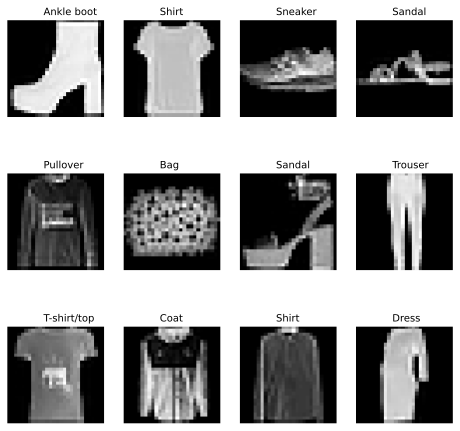

In [8]:
fig, axs = plt.subplots(3,4, figsize= (8,8))


for ax in axs.flatten():
    i = np.random.randint(1, 2000, 1 ).item()
    ax.imshow(images[i], cmap= 'gray')
    ax.text(10, -2, classes[labels[i]])
    ax.axis('off')

# plt.imshow(images[1], cmap= 'gray')
plt.show()

### working with data from google drive

In [9]:
# we already have the data and labels s follow
images = training_images()
labels = training_labels()
classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 
           4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

print (type(images))
print(images.shape)
print(' ')
print(type(labels))
print(labels.shape)

<class 'numpy.ndarray'>
(60000, 28, 28)
 
<class 'numpy.ndarray'>
(60000,)


In [10]:
# let's Normalize the data

dataNorm = images / np.max(images)
print(dataNorm.shape)

print(np.min(images), np.max(images))
print(np.min(dataNorm), np.max(dataNorm))

(60000, 28, 28)
0 255
0.0 1.0


In [11]:
# now we have to eshape it to (Number of images, number of channels, Number of H pixels, Number of W pixels)

dataNorm = dataNorm.reshape(dataNorm.shape[0], 1, 28, 28)
print(dataNorm.shape)

(60000, 1, 28, 28)


In [12]:
# creating train/test groups using dataloader

# step1 : convert to tensor

dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# step 2 : we have to split the training and test data using scikit learn function
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT,
                                                                    test_size= 0.1)

# step 3 : convert into PyTorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# step 4 : Create dataloaders
trainloader = DataLoader(train_data, batch_size= 32, shuffle= True, drop_last= True)
testloader = DataLoader(test_data, batch_size= 256)

In [13]:
# check size (should be images X channels X width X height)
print(trainloader.dataset.tensors[0].shape)
print(testloader.dataset.tensors[0].shape)
print(labelsT.shape)

torch.Size([54000, 1, 28, 28])
torch.Size([6000, 1, 28, 28])
torch.Size([60000])


### Create the NN model function

In [14]:
def FMNISTmodel(print_option= False):
    class fmnist(nn.Module):
        def __init__(self, print_option):
            super().__init__()

            # convolution layers
            self.convolution1 = nn.Conv2d(1, 10, kernel_size= 5, stride=1, padding= 1)   # size : np.floor((28+ 2*1 -5)/1) + 1 =26  ---> maxpooling 26/2 = 13
            self.convolution2 = nn.Conv2d(10, 20, kernel_size= 5, stride=1, padding= 1)  # size : np.floor((13+ 2*1 -5)/1) + 1 =11  ---> maxpooling 11/2 = 5
            self.convolution3 = nn.Conv2d(20, 40, kernel_size= 3, stride= 1, padding= 1) # size : np.floor((5+ 2*1 -3)/1) + 1 = 5    ---> maxpooling 5/2 = 2
            expectSize = 40* (int((np.floor((5+ 2*1 -3)/1) + 1)/2)**2)
            
            # Fully connected layers
            self.ffn1 = nn.Linear(expectSize, 80)
            self.ffn2 = nn.Linear(80, 50)
            self.output = nn.Linear(50, 10)

            self.print = print_option

        def forward(self, x):

            if self.print : print(x.shape)
            # Convolution Layers
            x = F.leaky_relu(F.max_pool2d(self.convolution1(x), 2))
            if self.print : print(x.shape)
            x = F.leaky_relu(F.max_pool2d(self.convolution2(x), 2))
            if self.print : print(x.shape)
            x = F.leaky_relu(F.max_pool2d(self.convolution3(x), 2))
            if self.print : print(x.shape)

            # reshape the matrix for Linear laye input
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            if self.print : print('Vectorized matrix  ',x.shape)

            # Linear Layers
            x = F.leaky_relu(self.ffn1(x))
            if self.print : print(x.shape)
            x = F.leaky_relu(self.ffn2(x))
            if self.print : print(x.shape)
            x = self.output(x)
            if self.print : print(x.shape)

            return x
        
    net = fmnist(print_option)
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params = net.parameters(), lr= 0.001, weight_decay= 0.00001)

    return net, lossfun, optimizer

In [15]:
# test with one batch of data

net, loss, opt = FMNISTmodel(print_option= True)

X, y = next(iter(trainloader))
yHat = net(X)

print('yHat shape:', yHat.shape)
print(y.shape)
print(' ')
lossvalue = loss(yHat, y)
print(lossvalue)

torch.Size([32, 1, 28, 28])
torch.Size([32, 10, 13, 13])
torch.Size([32, 20, 5, 5])
torch.Size([32, 40, 2, 2])
Vectorized matrix   torch.Size([32, 160])
torch.Size([32, 80])
torch.Size([32, 50])
torch.Size([32, 10])
yHat shape: torch.Size([32, 10])
torch.Size([32])
 
tensor(2.3030, grad_fn=<NllLossBackward0>)


In [16]:
from torchsummary import summary
# summary(net,(1,28,28))

### Create a function to train the model 

In [17]:
# Create a model to train the NN model

def trainmodel(number_of_epochs = 1):

    numberepochs = number_of_epochs

    net, lossfun, optimizer = FMNISTmodel(print_option= False)
    net.to(device)

    trainloss = torch.zeros(numberepochs)
    trainAcc = torch.zeros(numberepochs)
    testAcc  = []

    for epoch in range(numberepochs):
        print('Starting epoch is: ', epoch+1)
        net.train()
        batchAcc = []
        batchloss = []

        for X,y in trainloader:

            X = X.to(device)
            y= y.to(device)

            yHat = net(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchloss.append(loss.item())

            # compute accuracy
            matches_bool = torch.argmax(yHat, axis=1) == y        # booleans (false/true)
            matches_numeric = matches_bool.float()                # convert to numbers (0/1)
            accuracy_percent = 100 * torch.mean(matches_numeric)  # average and x100
            batchAcc.append(accuracy_percent.item())

            # end of a batch
        
        trainAcc[epoch] = np.mean(batchAcc).item()
        trainloss[epoch] = np.mean(batchloss).item()

        
        net.eval()
        for X, y in testloader:
            X= X.to(device)
            y= y.to(device)

            batchloss = []
            batchAcc = []
            with torch.no_grad():
                yHat = net(X)
            batchloss.append(lossfun(yHat, y).item())
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
        testAcc.append( np.mean(batchAcc))
        
        print('Number of Epoch finished: ', epoch+1)
        # end of one epoch
    
    return trainAcc, testAcc, trainloss


In [18]:
%%time
trainAcc , testAcc, trainloss = trainmodel(number_of_epochs = 10)

Starting epoch is:  1
Number of Epoch finished:  1
Starting epoch is:  2
Number of Epoch finished:  2
Starting epoch is:  3
Number of Epoch finished:  3
Starting epoch is:  4
Number of Epoch finished:  4
Starting epoch is:  5
Number of Epoch finished:  5
Starting epoch is:  6
Number of Epoch finished:  6
Starting epoch is:  7
Number of Epoch finished:  7
Starting epoch is:  8
Number of Epoch finished:  8
Starting epoch is:  9
Number of Epoch finished:  9
Starting epoch is:  10
Number of Epoch finished:  10
CPU times: user 1min 42s, sys: 2.71 s, total: 1min 44s
Wall time: 1min 51s


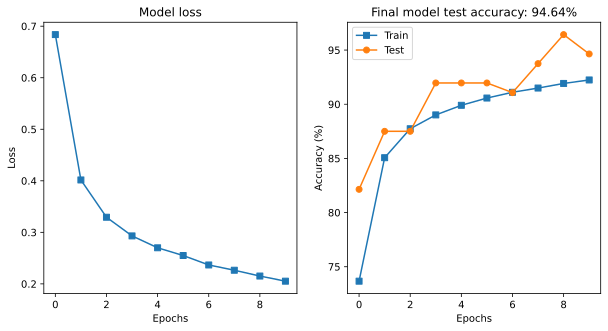

In [19]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(trainloss,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# 2- from torchvision

In [20]:
# # transformations
# transform = T.Compose([ T.ToTensor(),
#                         T.Normalize([.5,.5,.5],[.5,.5,.5])
#                        ])

# trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
# devtest  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

In [21]:
# print(trainset.data.shape)
# print(devtest.data.shape)
# print(trainset.classes)
# print(len(trainset.classes))
# print(trainset.targets)

# COURSE: A deep understanding of deep learning
## SECTION: CNN milestone projects
### LECTURE: Project 3: FMNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202108

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

# for importing data
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
devtest  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset))
test_loader  = DataLoader(testset, batch_size=len(testset))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
# check out the shape of the datasets
print('Data shapes (train/dev/test):')
print( len(trainset) )
print( len(devset) )
print( len(testset) )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(trainset.data),torch.max(trainset.data)) )

# the unique categories
print('\nData categories:')
print( trainset.classes )

Data shapes (train/dev/test):
60000
6000
4000

Data value range:
(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

Data categories:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [5]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 1x28x328
# And they are not normalized!

# but...
X,y = next(iter(test_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([4000, 1, 28, 28])

Data value range:
(tensor(-1.), tensor(1.))


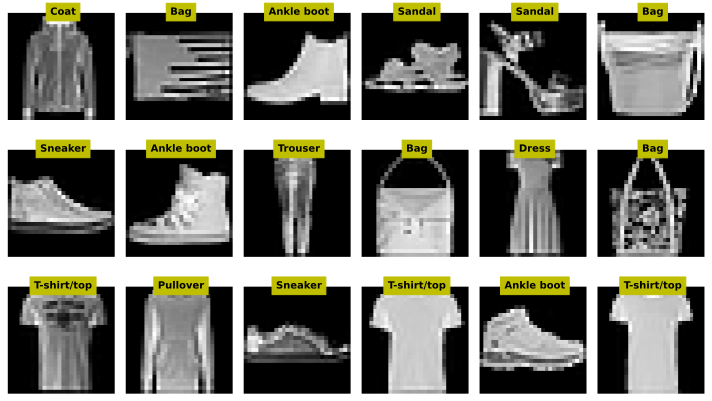

In [6]:
# inspect a few random images

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization
  
  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

## Create the DL model

In [7]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class cnnnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,16,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(16) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(16,32,3)
      self.bnorm2 = nn.BatchNorm2d(32) # input the number of channels in this layer
      # output size: (14+2*0-3)/1 + 1 = 12/2 = 6 (/2 b/c maxpool)
      
      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(6*6*32,64)
      self.fc2 = nn.Linear(64,32)
      self.fc3 = nn.Linear(32,10)

    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')
      
      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = F.dropout(x,p=.5,training=self.training)
      x = F.leaky_relu(self.fc2(x))
      x = F.dropout(x,p=.5,training=self.training) # training=self.training means to turn off during eval mode
      x = self.fc3(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = cnnnet(printtoggle)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [8]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(True)

X,y = iter(train_loader).next()
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

Input: [32, 1, 28, 28]
First CPR block: [32, 16, 14, 14]
Second CPR block: [32, 32, 6, 6]
Vectorized: [32, 1152]
Final output: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.3192, grad_fn=<NllLossBackward0>)


## Create a function that trains the model

In [9]:
# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeTheNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance
    net.eval() # switch to test mode
    X,y = next(iter(dev_loader))

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)

    # and get average losses and accuracies across the batches
    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

## Run the model and show the results!

In [10]:
%%time
# ~3 minutes with 10 epochs on GPU
trainLoss,devLoss,trainAcc,devAcc,net = funtion2trainTheModel()

CPU times: user 2min 41s, sys: 3.23 s, total: 2min 44s
Wall time: 2min 50s


In [11]:
## the real test set!

net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()

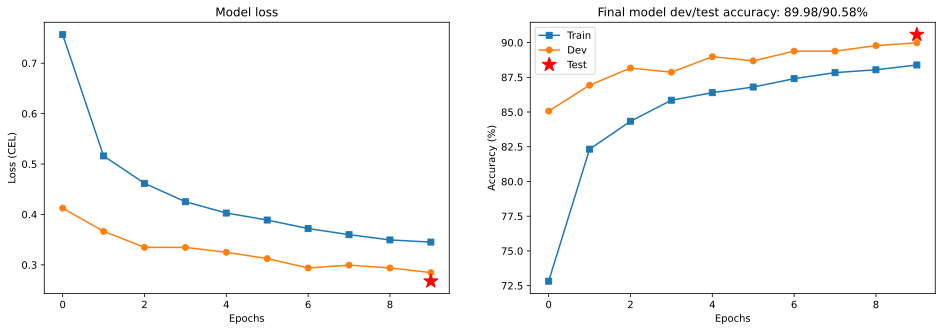

In [12]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()